# Part 2: Time Series Forecast with ARIMA (2 days) 📈

Welcome to the second part of your journey towards mastering the art of forecasting with ARIMA models. We will demystify ARIMA models, beginning with its foundational principles - autoregression, differencing, moving average. Using the same dataset as in Part 1, you will fit different models and assess their quality in order to compare them. You will also learn the different way of performing train/test splits and cross-validation in the context of time series!

In this notebook, we will cover the following concepts:
- Train / Test splitting for time series
- Naive forecasting models
- ARIMA and SARIMA models
- Cross-Validation for time series

**Objectives**
- Get to use few prediction models
- Understand Cross-Validation in the context of Time Series

**Ressources**

AR, MA, ARIMA :

- https://www.youtube.com/watch?v=Mc6sBAUdDP4&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=zNLG8tsA_Go&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=6
- https://www.youtube.com/watch?v=dXND1OEBABI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=7

ACF & PACF :

- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Métriques :

- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

Cross-validation :

- https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
- https://robjhyndman.com/hyndsight/tscv/

Forecasting: Principles and Practice livre (Rob Hyndman) :

- https://otexts.com/fpp2/
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://otexts.com/fpp2/transformations.html
- https://otexts.com/fpp2/seasonal-arima.html

Documentation de Pmdarima:

- http://alkaline-ml.com/pmdarima/


**Required librairies**
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima
- [ ] sktime

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import sktime as sk

# A bit of theory, again 😁

The ARMA (AutoRegressive Moving Average) model is suitable for predicting any time series whose value $Y$ at time $t$ can be explained by previous values and previous perturbations (noise).

Before specifying what a dataset is according to the ARIMA model, let's specify a dataset according to the conditions :  

- **Autoregressive**: the model predicts the variable $Y$ at time $t$, denoted $Y_t$, from previous values of $Y$ according to a linear regression model, i.e. $Y_{t-1}, Y_{t-2}, ..., Y_0$. Let $p$ denote the number of components used to predict $Y_t$, with

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, with $\varepsilon_t$ a perturbation, and c a constant.

- **Moving average**: a model where the data are the result of the moving average of order $q$. The value $Y_t$ can be expressed using the perturbation at time $t$ and its previous values:

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, with $\mu$ a constant.

Any ARMA model is the combination of the *AR* and *MA* conditions, i.e. it is autoregressive and its noise follows a moving average. Let :

> $Y_t = c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

or :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ with $\varepsilon_t$ the error of the autoregressive model at time $t$.

The model is optimized using the least-squares method.

An ARMA model is suitable for stationary data sets, i.e. with a fixed mean and standard deviation over time. Such data are rarely observed. Many time series datasets show trends in the mean or seasonal patterns. To do this, the problem must first be stationarized. As we saw before, this can be done by differencing the data, apply a model, and then performing the reverse operation: **integration**. An **ARIMA** model is said to be :

- **integrated**: when the data set can be corrected by running the model on $Y'_t = Y_t - Y_{t-1}$ for a correction of order 1 (d=1), or $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ for a correction of order 2 (d=2), etc...  We note $d$ the order of *correction by integration* to suppress polynomial tendencies of order $d$, with:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


ARIMA models are often denoted: ARIMA(p, d, q), or **ARIMA(2, 1, 1)** means :
- an autoregressive model of order 2,
- on data integrated 1 times,
- with a moving average of order 1.

# 1. Train / Test Splitting

Because the temporal order is important in time series, we cannot perform a random train/test split. Rather, we can use the most recent data (e.g. the last year) as the test set!

**TODO**
- Explain why train/test splitting can be a challenge for time series
- Write a function to split the dataset into a train and test set
- Use the function to split the airline passengers dataset, keeping the last twelve months as a test set
- Plot the train and test set in different colors

In [2]:
from sktime.datasets import load_airline

# Load dataset
airline = load_airline()

# Clean & Adjust the data
airline = airline.dropna()
airline_adj = airline / airline.index.days_in_month

In [3]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    
    # Your code here
    train = data[data.index < split_date]
    test = data[data.index >= split_date]
    return(train, test)


split_date : 1958-01-01 00:00:00


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

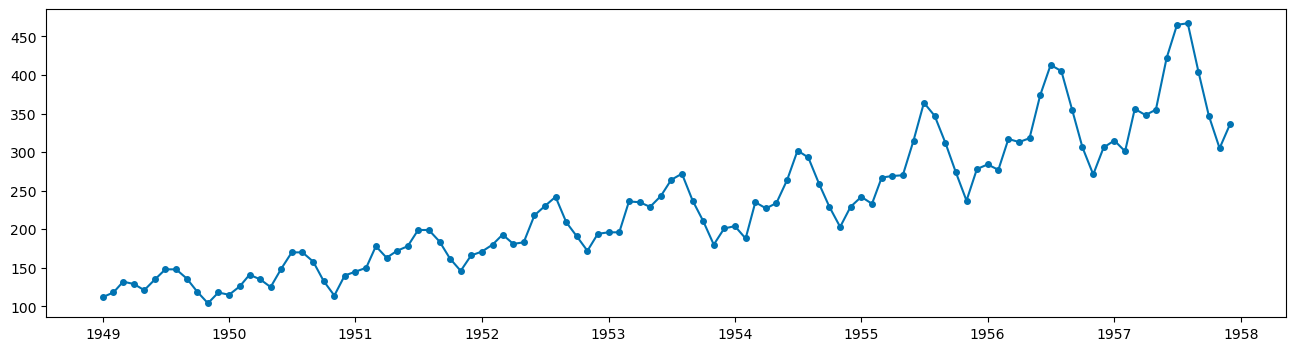

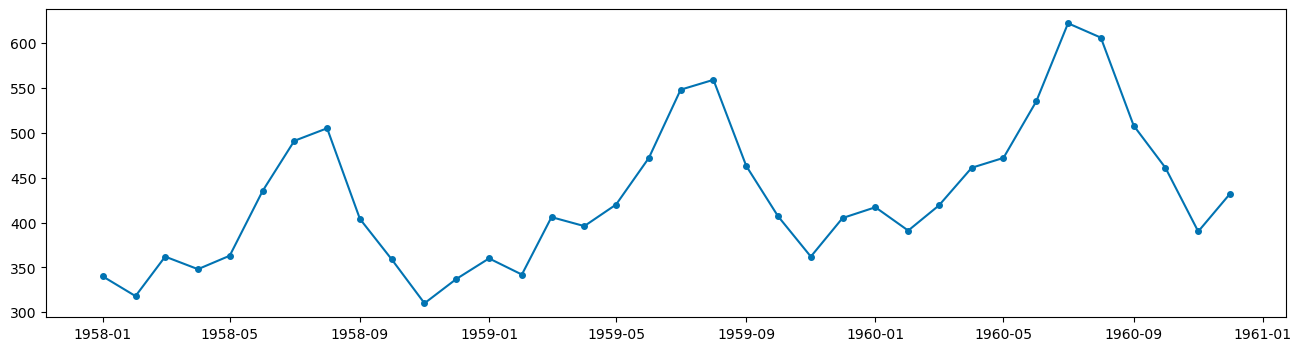

In [121]:
from sktime.utils.plotting import plot_series

# Hold back the last three years as a TEST set
split_date = airline[::12][-3:-2].index[0]
print(f"split_date : {split_date}")
train, test = ts_train_test_split(airline, split_date)
# Check train and test sizes are what we expect
train
test
# Plot the series
plot_series(train)
plot_series(test)


# 2. Naive Forecast

We need a baseline (as always!) to know if our more complex models are any use! Given the strong seasonal component that was confirmed by the seasonal decomposition we made earlier, it may be a good idea to use a **seasonal naive** forecasting method. This model takes the value from the same period in the previous season (in this case the same month last year). This is part of the Carry-Forward-Previous-Values' family of **naive** forecasting methods. In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words, we have yearly data so we just take the value from the same month last year.

In [123]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality

# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

### 2.1 Fit a Naive Forecaster

**TODO**
- Fit a Naive and Seasonal Naive forecaster to the train data, and show the predictions along with the test data.
- Plot the residuals using Seaborn's `displot()`, `regplot()` and `residplot()` functions.

In [ ]:
# Your code for the Naive Forecaster
model_naive = NaiveForecaster()
model_naive.fit(y= train,fh=fh)
nf_pred = model_naive.predict(fh)

In [125]:
# Your code for the Seasonal Naive Forecaster
model_naive_seasonal = NaiveForecaster(sp=12)
model_naive_seasonal.fit(y= train,fh=fh)
nfs_pred = model_naive_seasonal.predict(fh)

ValueError: <MonthBegin> is not supported as period frequency

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

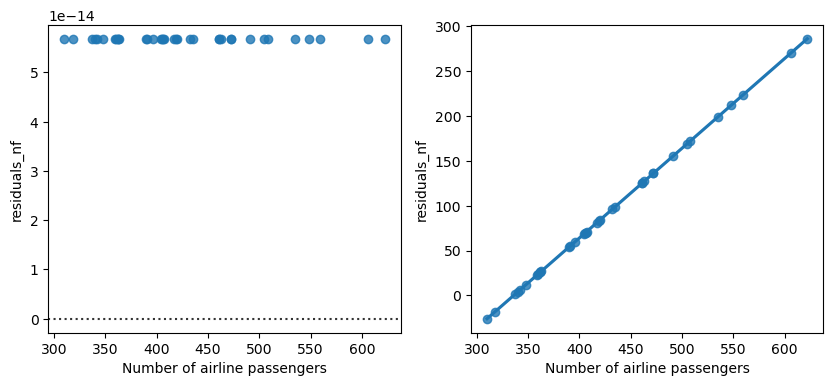

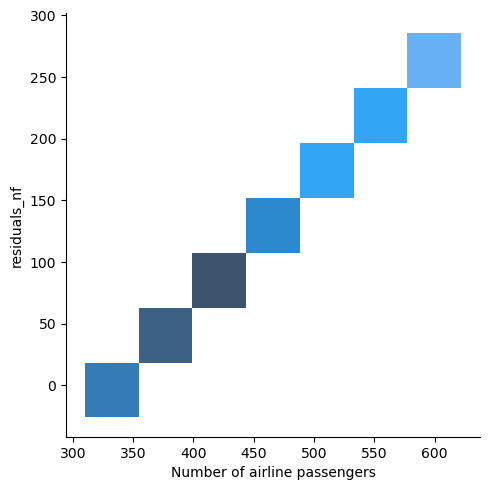

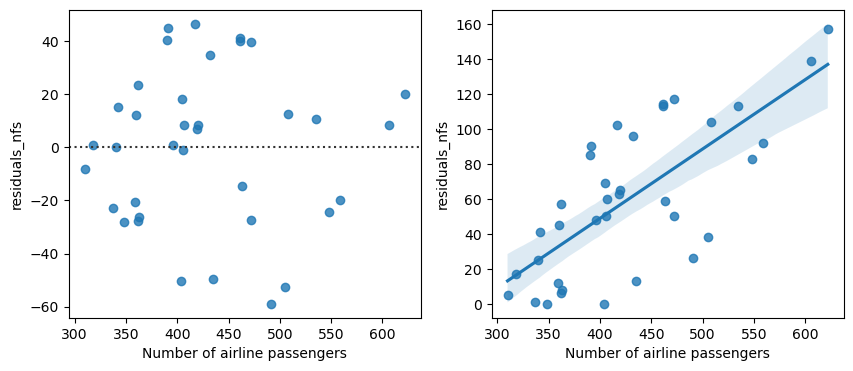

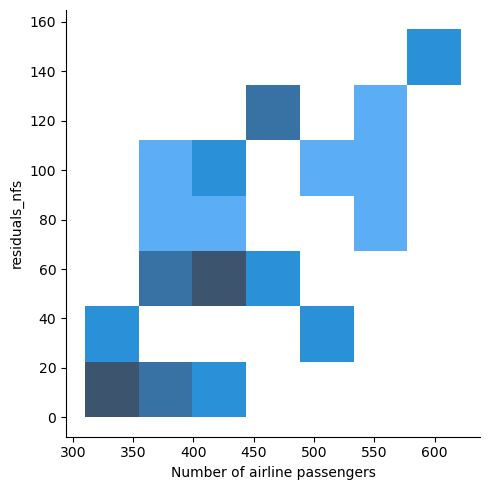

In [8]:
from seaborn import displot, regplot, residplot
# Your code here
fig,axes=plt.subplots(1,2,figsize=(10,4))
res_nf,res_nfs = test-nf_pred,test-nfs_pred
res_nf.name, res_nfs.name = "residuals_nf","residuals_nfs"
residplot(x=test,y=res_nf,ax=axes[0])
regplot(x=test,y=res_nf,ax=axes[1])
displot(x=test,y=res_nf)
fig,axes=plt.subplots(1,2,figsize=(10,4))
residplot(x=test,y=res_nfs, ax=axes[0])
regplot(x=test,y=res_nfs,ax=axes[1])
displot(x=test,y=res_nfs)

### 2.2 Error Metrics

You've probably already worked with the Mean Squared Error (MSE). Let's have a look at different metrics.

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

**TODO**
- Write a function to compute the MAPE
- Calculate the in-sample RMSE and MAPE for the last twelve months

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    
    
    # Your code here
    
    return(np.mean(100*np.abs((y_true-y_pred)/y_true)))

In [10]:
# Your code calculating the RMSE and MAPE for the Naive and Seasonal Naive models
mean_absolute_percentage_error(y_true=test,y_pred=nf_pred),mean_absolute_percentage_error(y_true=test,y_pred=nfs_pred)

(19.88671192699985, 13.189432350948401)

# 3. ARIMA Forecast

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over the options available in the core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember is that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formula for automatically selecting a good ARIMA forecasting model.

Even though modern applications tend to opt for the automatic approach for selecting the ARIMA parameters, we will have a go a trying and comparing how we perform with manual selection. As we discussed above, to train an ARIMA($p$,$d$,$q$) model we need to specify three parameters: $p$ (*AR*), $d$ (*I*) and $q$ (*MA*):
- To determine $p$, we look at the *direct* correlations, i.e. the *PACF*, and search for the lag $i$ such that $PACF_i \approx 0$
- To determine $q$, we look at the *full* correlations, i.e. the *ACF*, and search for the lag $i$ such that $ACF_i \approx 0$

Sometimes, we cannot apply directly these guidelines, and we must rely on a more detailed analysis or a grid search to determine the best $p,q$ for the problem at hand.

### Load the dataset & transform it

ARIMA models can take into account an increasing mean over time, but not the variance. Thus, a log transformation is enough for our purposes!

In [11]:
# Reload dataset from pmdarima
from pmdarima.datasets import load_airpassengers
from pmdarima.utils import acf, pacf
from pmdarima import ARIMA

# Load dataset
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no DateTimeIndex from the bundled dataset. So let's add one.
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')

# Clean & Adjust data
airline_adj = airline / airline.index.days_in_month

# Train / Test split
train, test = ts_train_test_split(airline_adj, '1960-01-01')

# Apply log transformation
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

### 3.1 Estimate $p$, $d$ and $q$

**TODO**
- Based on the analysis done on the previous notebook, what would be a plausible value for $d$ ?\
 d = 1, with lag =1 (to remove the trend) 
- Plot the ACF and PACF and determine some plausible values for $p$ and $q$.


In [12]:
def forecast(ARIMA_model, prediction_index, y_true=None,y_train=None):
    #copy just in case
    prediction_index, y_true,y_train=prediction_index.copy(), y_true.copy(),y_train.copy()
    # Forecast
    fitted, confint = ARIMA_model.predict(n_periods=len(prediction_index), return_conf_int=True)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=prediction_index)
    lower_series = pd.Series(confint[:, 0], index=prediction_index)
    upper_series = pd.Series(confint[:, 1], index=prediction_index)

    # Plot
    plt.figure(figsize=(15,7))
    if not y_train.equals(None) :
        plt.plot(y_train, color='#f97306', label='y_train')
    if not y_true.equals(None) :
        plt.plot(y_true, color='#1f76b4', label='y_true')
    plt.plot(fitted_series, color='darkgreen',label='y_pred')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.legend()
    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()
    return(fitted)

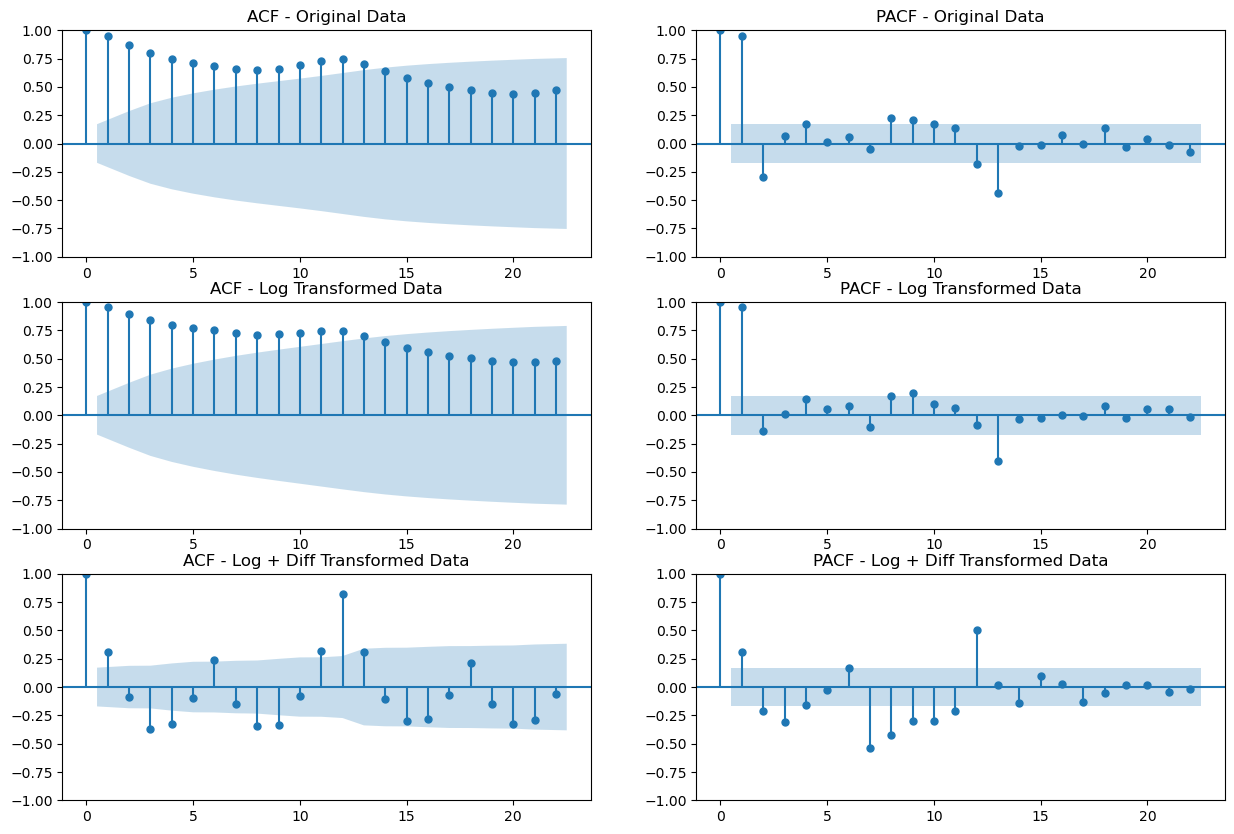

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Your code for the ACF & PACF plots
train_log_diff = pd.Series(train_log).diff(1)

# Plot the ACF and PACF
# Create figure with 6 subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))

# Original data
plot_acf(train, ax=ax1, title='ACF - Original Data')
plot_pacf(train, ax=ax2, title='PACF - Original Data')

# Log transformed data
plot_acf(train_log, ax=ax3, title='ACF - Log Transformed Data')
plot_pacf(train_log, ax=ax4, title='PACF - Log Transformed Data')

# Log + differenced data
plot_acf(train_log_diff.dropna(), ax=ax5, title='ACF - Log + Diff Transformed Data')
plot_pacf(train_log_diff.dropna(), ax=ax6, title='PACF - Log + Diff Transformed Data')

# plt.tight_layout()
plt.show()


- To determine $p$, we look at the *direct* correlations, i.e. the *PACF*, and search for the lag $i$ such that $PACF_i \approx 0$
p=12
- To determine $q$, we look at the *full* correlations, i.e. the *ACF*, and search for the lag $i$ such that $ACF_i \approx 0$
q=12

- Fit the ARIMA model and show the diagnostics using the `plot_diagnostics()` of pmdarima. Describe the different plots. How do you interpret these results ?

In [14]:
# Your code for the ARIMA model
from pmdarima import ARIMA

# Create ARIMA model with order (p=12, d=1, q=12) based on ACF/PACF analysis
model_ARIMA = ARIMA(order=(12,1,12))
model_ARIMA.fit(y=train_log)  # Fit using log-transformed data

# Make predictions and transform back
predictions_log = model_ARIMA.predict(n_periods=len(test))
predictions = np.exp(predictions_log)  # Transform back from log scale
predictions.name = 'daily passenger'


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

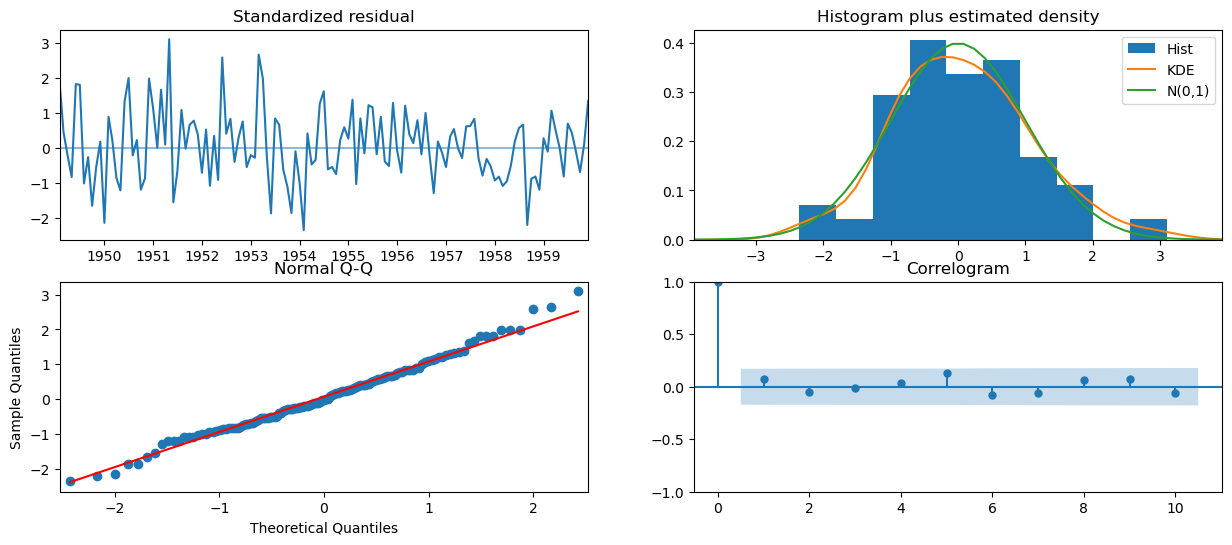

In [15]:
# Plot diagnostics
model_ARIMA.plot_diagnostics(figsize=(15,6))
plt.show()

**TODO**
- Make a figure showing the train set, the test set, the predictions from ARIMA and the confidence intervals
- Make a second figure showing the predictions for the next 100 periods
- Calculate the RMSE and the MAPE on the test set

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


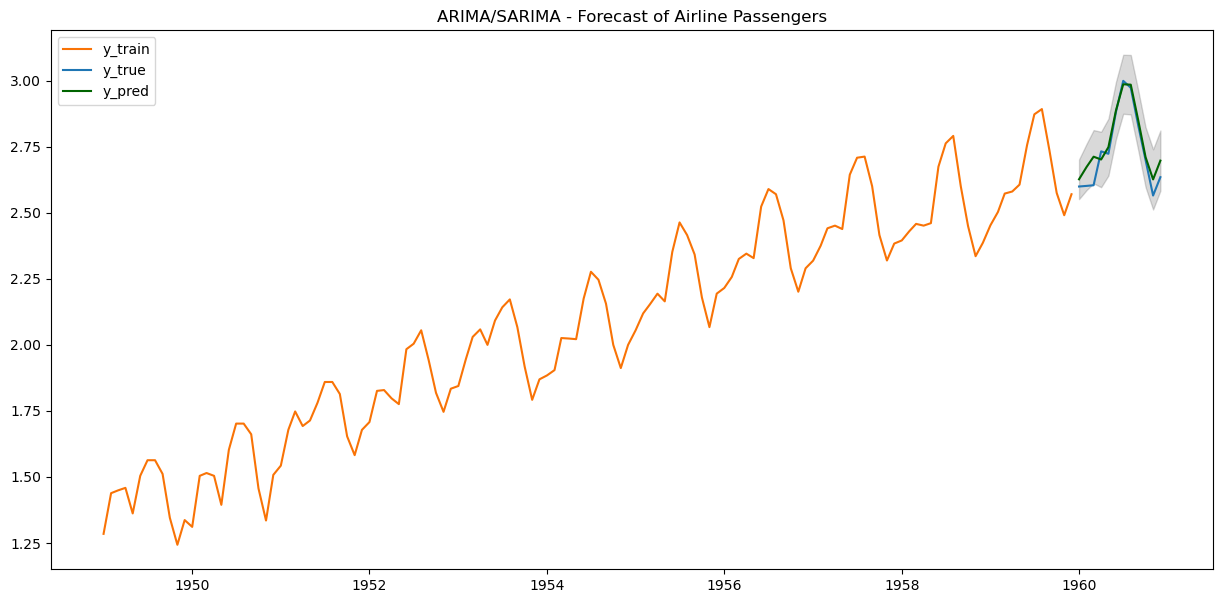

1960-01-01    2.626436
1960-02-01    2.672934
1960-03-01    2.711907
1960-04-01    2.701362
1960-05-01    2.748084
1960-06-01    2.886529
1960-07-01    2.985957
1960-08-01    2.984497
1960-09-01    2.848887
1960-10-01    2.710247
1960-11-01    2.625960
1960-12-01    2.697044
Freq: MS, dtype: float64

In [36]:
# Your code showing train, test, predictions and confidence interval
forecast(ARIMA_model=model_ARIMA, 
             prediction_index=test.index, 
             y_true=test_log,
             y_train=train_log)

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


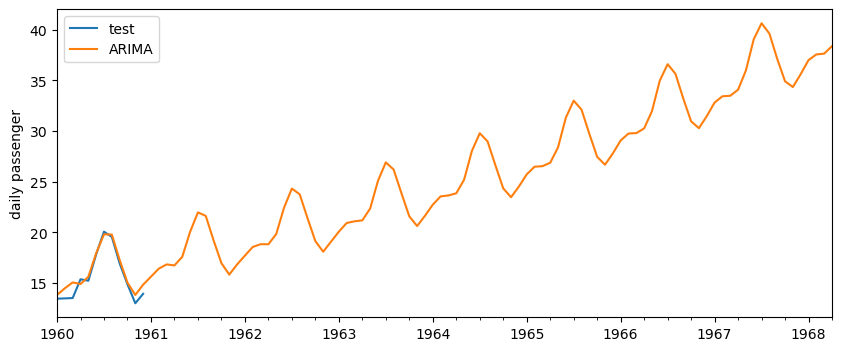

In [17]:
# Your code for showing the predictions for 100 periods
# Make predictions and transform back
predictions_log_100 = model_ARIMA.predict(n_periods=100)
predictions_100 = np.exp(predictions_log_100)  # Transform back from log scale
#plot
fig,ax0 = plt.subplots(1,1,figsize=(10,4))
test.plot(ax=ax0, label ="test")
predictions_100.plot(ax=ax0,label="ARIMA")
ax0.set_ylabel('daily passenger')
ax0.legend()

In [18]:
# Make predictions and transform back
predictions_log = model_ARIMA.predict(len(test.index))
predictions = np.exp(predictions_log)
from sklearn.metrics import mean_squared_error
# Your code calculating the RMSE and MAPE
df_result = pd.DataFrame(columns=['MAPE','MSE'], index = ['log_test','test'])
df_result.loc['log_test','MAPE'] = mean_absolute_percentage_error(test_log, predictions_log)
df_result.loc['log_test','MSE'] = mean_squared_error(test_log, predictions_log)
df_result.loc['test','MAPE'] = mean_absolute_percentage_error(test, predictions)
df_result.loc['test','MSE'] = mean_squared_error(test, predictions)
df_result


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAPE,MSE
log_test,1.405202,0.002299
test,3.833116,0.469142


**Conclusions**
- What are your conclusions ?
    
    The model is good and perfom better that the naive baseline 
- What do you think about the error?

The MAPE of 3.8% is satisfying to predict passenger number 

### 3.2 Seasonal ARIMA


As we have seen previously, ARMA models are well suited for stationary data. They may even works for data presenting seasonality, however seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

**Example** : Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of $p=12*12$ to comprehend seasonality of the problem!

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

The Seasonal ARIMA model, also known as SARIMA, is an extension of the basic ARIMA model that takes into account seasonality in the data. In a SARIMA model, we introduce additional seasonal components to the ARIMA model. The seasonal components mirror the ARIMA components but are applied to the seasonal patterns in the data. So, the SARIMA model has six additional parameters:

- Seasonal Autoregressive (SAR) component: This is similar to the AR component but for the seasonal patterns. It represents the relationship between the current value of the time series and its past values at the seasonal frequency.

- Seasonal Integrated (SI) component: This is similar to the I component but for the seasonal patterns. It involves differencing the time series at the seasonal frequency to achieve seasonality stationarity.

- Seasonal Moving Average (SMA) component: This is similar to the MA component but for the seasonal patterns. It models the relationship between the current value of the time series and past forecast errors at the seasonal frequency.

The seasonal frequency $s$ refers to the number of time periods that make up one seasonal cycle, and must also be provided to a SARIMA model. For example, if the time series exhibits a yearly seasonality, the seasonal frequency is 12 (assuming monthly data).

**TODO**
- Using a seasonal decomposition of the dataset, separate it into trend, seasonality and residual parts.
- Plot the moving mean and std of the trend and seasonal parts of the data.

In [19]:
def moving_mean(x, n):
    return x.rolling(n).mean()

def moving_std(x, n):
    return x.rolling(n).std()

(<matplotlib.legend.Legend at 0x7f6320d85640>,
 <matplotlib.legend.Legend at 0x7f6320e439b0>)

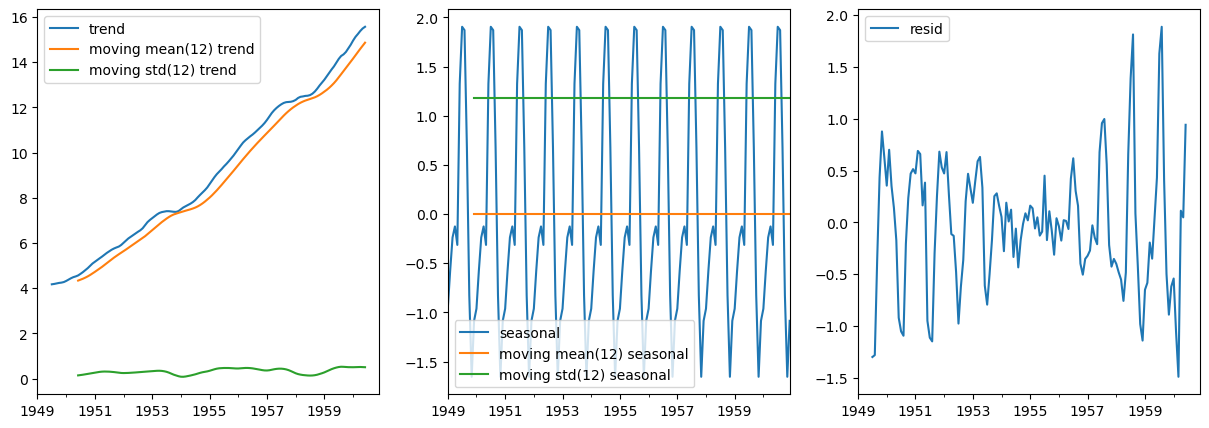

In [20]:
# Decompose the data into a trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(airline_adj)
trend_,seasonal_,resid_ = sd.trend,sd.seasonal,sd.resid
fig,axes = plt.subplots(1,3,figsize=(15,5))
trend_.plot(label='trend',ax=axes[0])
moving_mean(trend_,12).plot(label='moving mean(12) trend',ax=axes[0])
moving_std(trend_,12).plot(label='moving std(12) trend',ax=axes[0])

seasonal_.plot(label='seasonal',ax=axes[1])
moving_mean(seasonal_,12).plot(label='moving mean(12) seasonal',ax=axes[1])
moving_std(seasonal_,12).plot(label='moving std(12) seasonal',ax=axes[1])

resid_.plot(label = 'resid',ax=axes[2])
axes[0].legend(),axes[1].legend(),axes[2].legend()


**TODO**
- What can you conclude about stationarity of seasonal data? Can you then define $D$ and the seasonal frequency $s$ ?

    The seasonal data is stationary,  D ???, s =12 (period)

- Does intra-seasonal data show specific seasonality ? What is $d$ (0, 1, or 2) ?
- Use the same procedure applied previously to a build a SARIMA model and evaluate its performance.

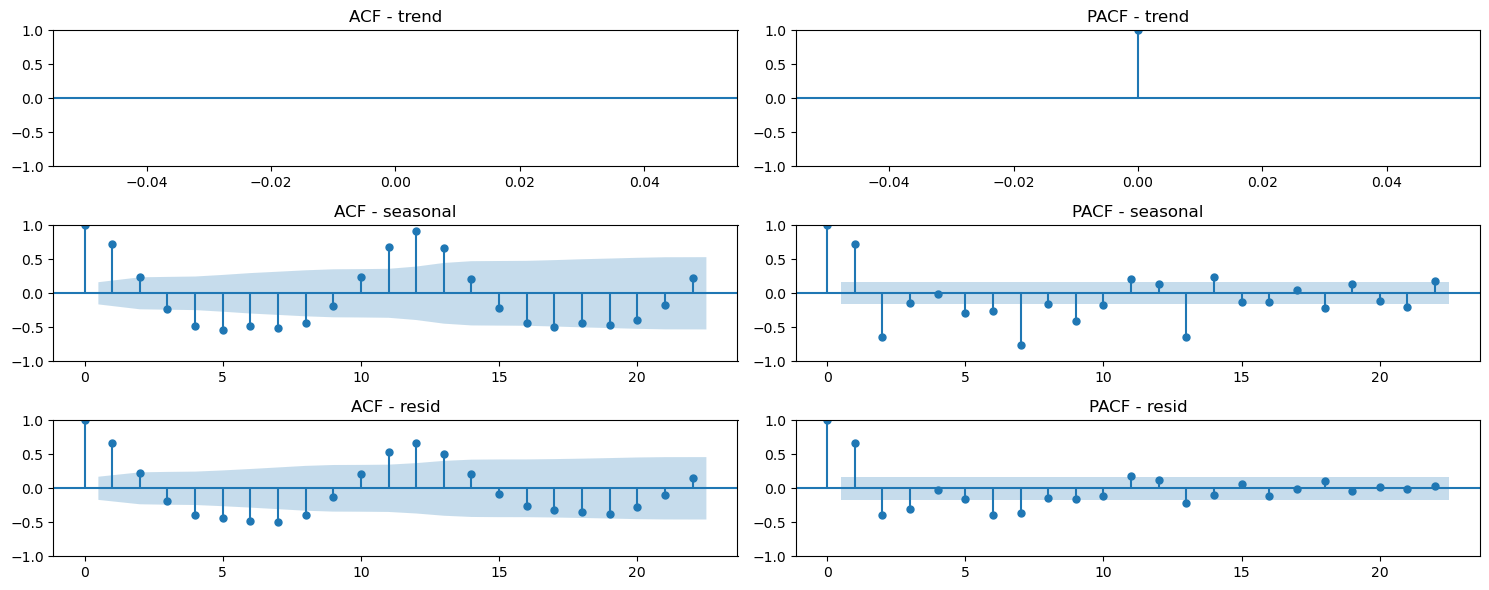

In [21]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure with 6 subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 6))

# Original data
plot_acf(trend_, ax=ax1, title='ACF - trend')
plot_pacf(trend_, ax=ax2, title='PACF - trend')

# Log transformed data
plot_acf(seasonal_, ax=ax3, title='ACF - seasonal')
plot_pacf(seasonal_, ax=ax4, title='PACF - seasonal')

# resid
plot_acf(resid_.dropna(), ax=ax5, title='ACF - resid')
plot_pacf(resid_.dropna(), ax=ax6, title='PACF - resid')

plt.tight_layout()
plt.show()


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digita

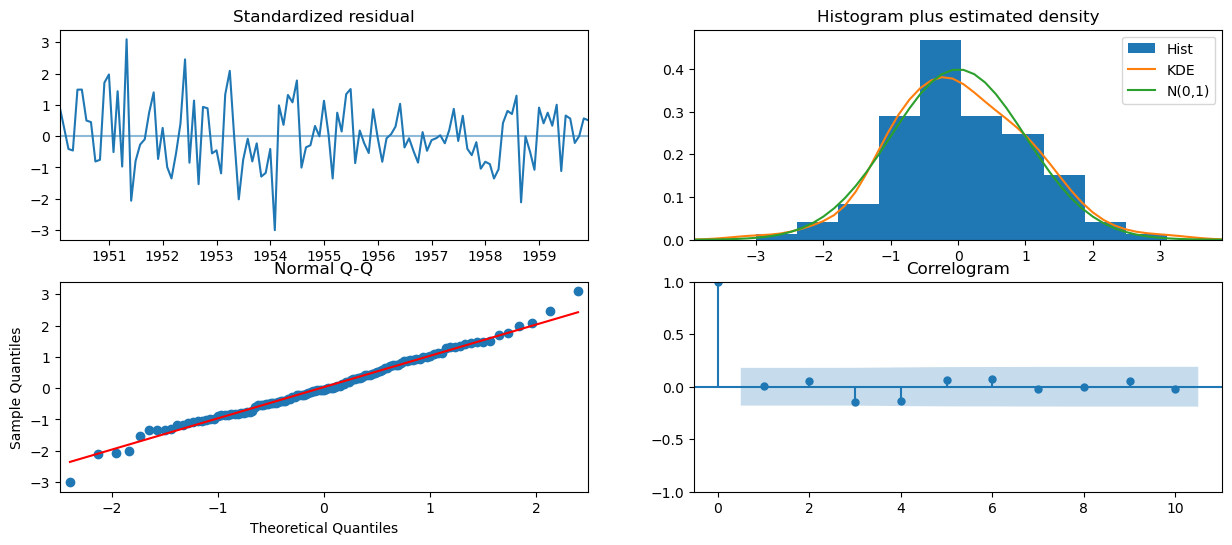

In [22]:
# Fit the SARIMA model

# import statsmodels as ss
# model_SARIMA = ss.tsa.statespace.sarimax.SARIMAX(train, 
#                                 order=(11,1,11), 
#                                 seasonal_order=(0,1,1,12), 
#                                 trend='c').fit(disp=False)

# Seasonal - fit stepwise auto-ARIMA
model_SARIMA = pm.auto_arima(train_log, start_p=1, start_q=1,s=12,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
model_SARIMA.summary()  
# Plot diagnostics
model_SARIMA.plot_diagnostics(figsize=(15,6))
plt.show()

In [23]:
model_SARIMA.predict(len(test_log.index))

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1960-01-01    2.605269
1960-02-01    2.653746
1960-03-01    2.711700
1960-04-01    2.717954
1960-05-01    2.726817
1960-06-01    2.904274
1960-07-01    3.000865
1960-08-01    3.014164
1960-09-01    2.866338
1960-10-01    2.703146
1960-11-01    2.607852
1960-12-01    2.681158
Freq: MS, dtype: float64

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


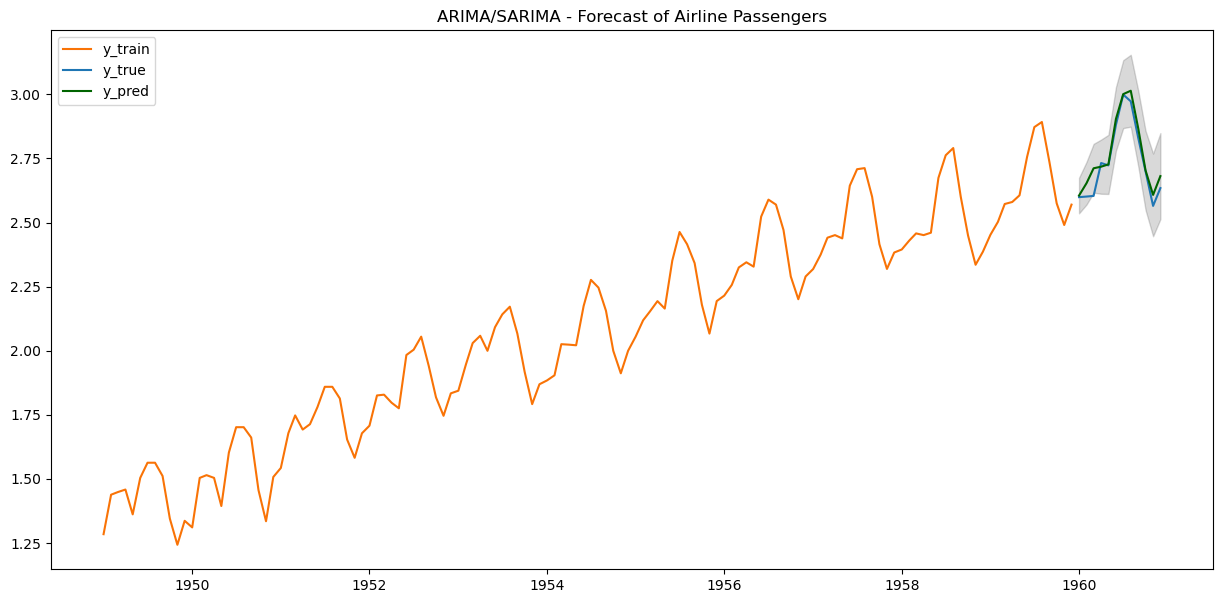

1960-01-01    2.605269
1960-02-01    2.653746
1960-03-01    2.711700
1960-04-01    2.717954
1960-05-01    2.726817
1960-06-01    2.904274
1960-07-01    3.000865
1960-08-01    3.014164
1960-09-01    2.866338
1960-10-01    2.703146
1960-11-01    2.607852
1960-12-01    2.681158
Freq: MS, dtype: float64

In [37]:
# Show train, test, predictions and confidence interval
forecast(ARIMA_model=model_SARIMA,prediction_index=test.index,y_true=test_log,y_train=train_log)

In [25]:
# Make predictions and transform back
predictions_log = model_SARIMA.predict(len(test.index))
predictions = np.exp(predictions_log)
from sklearn.metrics import mean_squared_error
# Your code calculating the RMSE and MAPE
df_result = pd.DataFrame(columns=['MAPE','MSE'], index = ['log_test','test'])
df_result.loc['log_test','MAPE'] = mean_absolute_percentage_error(test_log, predictions_log)
df_result.loc['log_test','MSE'] = mean_squared_error(test_log, predictions_log)
df_result.loc['test','MAPE'] = mean_absolute_percentage_error(test, predictions)
df_result.loc['test','MSE'] = mean_squared_error(test, predictions)
df_result

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAPE,MSE
log_test,1.183599,0.001856
test,3.270155,0.415488


**Conclusions**
- What are your conclusions with respect to the previous ARIMA model ?

### 3.3 Auto-Arima  🎉

Auto ARIMA is an automated time series forecasting method that automatically selects the best combination of ARIMA model parameters ($p$, $d$, $q$) based on the data's characteristics. It uses algorithms to iteratively search and evaluate different models to find the most suitable one, saving users from manually tuning the parameters. Auto ARIMA is a powerful tool for efficiently forecasting time series data, especially when dealing with large datasets or when users have limited knowledge of time series modeling.

**TODO**
- Fit an `auto_arima` model and plot the diagnostics.
- How does it compare to the best model you found previously ?

In [69]:
model_auto_ARIMA = pm.auto_arima(y=train_log, 
                      start_p=0,max_p=12, 
                      start_q=0,max_q=12,
                      start_d=0,max_d=12,
                      max_order=None,
                      stepwise=False,
                      trace=True)
                    #   test='adf', # use adftest to find optimal 'd'
                    #   # m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                    #   seasonal=False, # No Seasonality for standard ARIMA
                    #   trace=False, #logs 
                    # #   error_action='warn', #shows errors ('ignore' silences these)
                    #   suppress_warnings=True,
                    #   )

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digita

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-234.171, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-247.706, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-247.076, Time=0.11 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-290.524, Time=0.30 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=-305.140, Time=0.32 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=-303.286, Time=0.40 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,8)(0,0,0)[1] intercept   : AIC=-293.703, Time=0.50 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,9)(0,0,0)[1] intercept   : AIC=-305.268, Time=0.59 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=0.90 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,11)(0,0,0)[1] intercept   : AIC=-300.656, Time=1.02 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,12)(0,0,0)[1] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-245.944, Time=0.07 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-246.151, Time=0.14 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC=-304.001, Time=0.60 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,7)(0,0,0)[1] intercept   : AIC=-301.922, Time=0.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.61 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,9)(0,0,0)[1] intercept   : AIC=-295.851, Time=0.65 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=0.75 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,11)(0,0,0)[1] intercept   : AIC=-298.711, Time=0.99 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,12)(0,0,0)[1] intercept   : AIC=-333.750, Time=1.62 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-250.157, Time=0.06 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-285.223, Time=0.27 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-284.960, Time=0.35 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.49 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[1] intercept   : AIC=-290.893, Time=0.56 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,6)(0,0,0)[1] intercept   : AIC=-297.561, Time=0.46 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,7)(0,0,0)[1] intercept   : AIC=-293.259, Time=0.71 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,8)(0,0,0)[1] intercept   : AIC=-305.872, Time=0.64 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,9)(0,0,0)[1] intercept   : AIC=-307.677, Time=0.79 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,10)(0,0,0)[1] intercept   : AIC=-312.776, Time=0.84 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,11)(0,0,0)[1] intercept   : AIC=-327.299, Time=0.98 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,12)(0,0,0)[1] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=-261.962, Time=0.16 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=-285.421, Time=0.42 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=-255.293, Time=0.42 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[1] intercept   : AIC=-284.758, Time=0.48 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[1] intercept   : AIC=-286.377, Time=0.52 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.67 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,6)(0,0,0)[1] intercept   : AIC=-296.466, Time=0.72 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,7)(0,0,0)[1] intercept   : AIC=inf, Time=0.74 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,8)(0,0,0)[1] intercept   : AIC=-307.630, Time=0.79 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,9)(0,0,0)[1] intercept   : AIC=-311.645, Time=1.01 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,10)(0,0,0)[1] intercept   : AIC=-311.397, Time=0.83 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,11)(0,0,0)[1] intercept   : AIC=-321.505, Time=1.06 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,12)(0,0,0)[1] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(4,1,0)(0,0,0)[1] intercept   : AIC=-264.046, Time=0.09 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[1] intercept   : AIC=-262.063, Time=0.29 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[1] intercept   : AIC=-295.783, Time=0.54 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.72 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[1] intercept   : AIC=-283.742, Time=0.52 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.59 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,6)(0,0,0)[1] intercept   : AIC=-294.562, Time=0.73 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,7)(0,0,0)[1] intercept   : AIC=-307.958, Time=0.74 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,9)(0,0,0)[1] intercept   : AIC=-303.912, Time=1.22 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=1.19 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,11)(0,0,0)[1] intercept   : AIC=inf, Time=1.24 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,12)(0,0,0)[1] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(5,1,0)(0,0,0)[1] intercept   : AIC=-262.096, Time=0.19 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[1] intercept   : AIC=-275.458, Time=0.43 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[1] intercept   : AIC=-292.781, Time=0.52 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[1] intercept   : AIC=-282.687, Time=0.50 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.52 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.68 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.85 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,7)(0,0,0)[1] intercept   : AIC=inf, Time=0.81 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,9)(0,0,0)[1] intercept   : AIC=inf, Time=1.01 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=1.09 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,11)(0,0,0)[1] intercept   : AIC=-321.921, Time=1.11 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,12)(0,0,0)[1] intercept   : AIC=-351.255, Time=1.16 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,0)(0,0,0)[1] intercept   : AIC=-264.558, Time=0.34 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,1)(0,0,0)[1] intercept   : AIC=-276.535, Time=0.50 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,2)(0,0,0)[1] intercept   : AIC=-307.896, Time=0.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,3)(0,0,0)[1] intercept   : AIC=-299.207, Time=0.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.58 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,5)(0,0,0)[1] intercept   : AIC=-290.636, Time=0.72 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,6)(0,0,0)[1] intercept   : AIC=inf, Time=0.68 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,7)(0,0,0)[1] intercept   : AIC=inf, Time=0.75 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.78 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,9)(0,0,0)[1] intercept   : AIC=inf, Time=0.82 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,11)(0,0,0)[1] intercept   : AIC=-310.555, Time=1.09 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(6,1,12)(0,0,0)[1] intercept   : AIC=-362.100, Time=1.18 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,0)(0,0,0)[1] intercept   : AIC=-314.974, Time=0.49 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,1)(0,0,0)[1] intercept   : AIC=-360.547, Time=0.45 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,2)(0,0,0)[1] intercept   : AIC=-388.056, Time=0.56 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,3)(0,0,0)[1] intercept   : AIC=-359.541, Time=0.63 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,4)(0,0,0)[1] intercept   : AIC=-325.609, Time=0.58 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,5)(0,0,0)[1] intercept   : AIC=-342.082, Time=0.64 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,6)(0,0,0)[1] intercept   : AIC=-381.701, Time=0.71 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,7)(0,0,0)[1] intercept   : AIC=-424.729, Time=0.73 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,8)(0,0,0)[1] intercept   : AIC=-424.863, Time=0.78 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,9)(0,0,0)[1] intercept   : AIC=-433.823, Time=0.94 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,10)(0,0,0)[1] intercept   : AIC=-427.894, Time=0.99 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,11)(0,0,0)[1] intercept   : AIC=inf, Time=1.18 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(7,1,12)(0,0,0)[1] intercept   : AIC=-356.474, Time=1.49 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,0)(0,0,0)[1] intercept   : AIC=-347.156, Time=0.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,1)(0,0,0)[1] intercept   : AIC=-372.518, Time=0.51 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,2)(0,0,0)[1] intercept   : AIC=-366.964, Time=0.55 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,3)(0,0,0)[1] intercept   : AIC=-366.058, Time=0.69 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,4)(0,0,0)[1] intercept   : AIC=-381.696, Time=0.73 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.81 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,6)(0,0,0)[1] intercept   : AIC=-398.332, Time=0.77 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,7)(0,0,0)[1] intercept   : AIC=-428.253, Time=0.83 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,8)(0,0,0)[1] intercept   : AIC=-431.081, Time=0.87 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,9)(0,0,0)[1] intercept   : AIC=-432.668, Time=1.03 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,10)(0,0,0)[1] intercept   : AIC=-428.785, Time=1.09 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,11)(0,0,0)[1] intercept   : AIC=-427.619, Time=1.40 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(8,1,12)(0,0,0)[1] intercept   : AIC=-388.678, Time=1.45 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,0)(0,0,0)[1] intercept   : AIC=-365.685, Time=0.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,1)(0,0,0)[1] intercept   : AIC=-377.666, Time=0.56 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,2)(0,0,0)[1] intercept   : AIC=-373.046, Time=0.72 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,3)(0,0,0)[1] intercept   : AIC=-400.447, Time=0.94 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,4)(0,0,0)[1] intercept   : AIC=-388.744, Time=0.98 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,5)(0,0,0)[1] intercept   : AIC=-405.983, Time=1.01 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,6)(0,0,0)[1] intercept   : AIC=-401.840, Time=0.86 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,7)(0,0,0)[1] intercept   : AIC=-415.038, Time=0.94 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,8)(0,0,0)[1] intercept   : AIC=inf, Time=0.93 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,9)(0,0,0)[1] intercept   : AIC=-425.568, Time=1.21 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,10)(0,0,0)[1] intercept   : AIC=inf, Time=1.62 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,11)(0,0,0)[1] intercept   : AIC=-419.631, Time=2.06 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,12)(0,0,0)[1] intercept   : AIC=-412.326, Time=1.80 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,0)(0,0,0)[1] intercept   : AIC=inf, Time=0.73 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,1)(0,0,0)[1] intercept   : AIC=-378.300, Time=0.69 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(0,0,0)[1] intercept   : AIC=-375.018, Time=0.80 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,3)(0,0,0)[1] intercept   : AIC=-377.035, Time=0.91 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,4)(0,0,0)[1] intercept   : AIC=-384.966, Time=0.97 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,5)(0,0,0)[1] intercept   : AIC=-406.149, Time=1.11 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,6)(0,0,0)[1] intercept   : AIC=-415.658, Time=1.29 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,7)(0,0,0)[1] intercept   : AIC=-440.840, Time=1.11 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,8)(0,0,0)[1] intercept   : AIC=-414.434, Time=1.41 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,9)(0,0,0)[1] intercept   : AIC=-424.479, Time=1.29 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,10)(0,0,0)[1] intercept   : AIC=-424.335, Time=1.34 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,11)(0,0,0)[1] intercept   : AIC=-405.890, Time=1.60 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,12)(0,0,0)[1] intercept   : AIC=-409.154, Time=1.41 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,0)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,1)(0,0,0)[1] intercept   : AIC=-404.977, Time=0.78 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,2)(0,0,0)[1] intercept   : AIC=-429.666, Time=1.14 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,3)(0,0,0)[1] intercept   : AIC=-426.964, Time=1.12 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,4)(0,0,0)[1] intercept   : AIC=-431.489, Time=1.15 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,5)(0,0,0)[1] intercept   : AIC=-431.598, Time=1.33 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,6)(0,0,0)[1] intercept   : AIC=-436.023, Time=1.02 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,7)(0,0,0)[1] intercept   : AIC=-442.185, Time=1.13 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,8)(0,0,0)[1] intercept   : AIC=-425.393, Time=1.57 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,9)(0,0,0)[1] intercept   : AIC=-435.421, Time=1.51 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,10)(0,0,0)[1] intercept   : AIC=-438.885, Time=1.70 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,11)(0,0,0)[1] intercept   : AIC=-400.289, Time=1.49 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,12)(0,0,0)[1] intercept   : AIC=-408.033, Time=1.92 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,0)(0,0,0)[1] intercept   : AIC=inf, Time=0.77 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,1)(0,0,0)[1] intercept   : AIC=-441.077, Time=0.93 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,2)(0,0,0)[1] intercept   : AIC=-438.253, Time=0.97 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,3)(0,0,0)[1] intercept   : AIC=-437.975, Time=1.29 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,4)(0,0,0)[1] intercept   : AIC=-433.790, Time=1.34 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,5)(0,0,0)[1] intercept   : AIC=-432.646, Time=1.42 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,6)(0,0,0)[1] intercept   : AIC=-433.178, Time=1.64 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,7)(0,0,0)[1] intercept   : AIC=-431.239, Time=1.65 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,8)(0,0,0)[1] intercept   : AIC=-421.437, Time=1.61 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,9)(0,0,0)[1] intercept   : AIC=-417.685, Time=1.65 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,10)(0,0,0)[1] intercept   : AIC=-415.954, Time=1.58 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,11)(0,0,0)[1] intercept   : AIC=-421.163, Time=1.76 sec


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(12,1,12)(0,0,0)[1] intercept   : AIC=-414.460, Time=1.78 sec

Best model:  ARIMA(11,1,7)(0,0,0)[1] intercept
Total fit time: 145.111 seconds


In [ ]:
model_auto_ARIMA.summary()
#Best model:  ARIMA(11,1,7)(0,0,0)[1] intercept


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:              SARIMAX(11, 1, 7)   Log Likelihood                 241.093
Date:                Fri, 01 Aug 2025   AIC                           -442.185
Time:                        13:58:22   BIC                           -384.682
Sample:                    01-01-1949   HQIC                          -418.819
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0563      0.011      4.988      0.000       0.034       0.078
ar.L1          0.0284      0.159      0.178      0.859      -0.284       0.341
ar.L2         -0.6989      0.097     -7.239      0.000      -0.888      -0.510
ar.L3         -0.4817      0.149     -3.234      0.001      -0.774      -0.190
ar.L4         -0.3497      0.125     -2.794      0.005      -0.595      -0.104
ar.L5         -0.7408      0.086     -8.604      0.000      -0.910      -0.572
ar.L6          0.0357      0.136      0.263      0.793      -0.230       0.302
ar.L7         -0.9536      0.052    -18.269      0.000      -1.056      -0.851
ar.L8         -0.2849      0.145     -1.967      0.049      -0.569      -0.001
ar.L9         -0.4472      0.104     -4.314      0.000      -0.650      -0.244
ar.L10        -0.5624      0.114     -4.953      0.000      -0.785      -0.340
ar.L11        -0.2012      0.125     -1.614      0.107      -0.446       0.043
ma.L1         -0.3913      0.159     -2.454      0.014      -0.704      -0.079
ma.L2          0.5675      0.126      4.512      0.000       0.321       0.814
ma.L3         -0.0101      0.169     -0.060      0.952      -0.341       0.321
ma.L4          0.1122      0.171      0.658      0.511      -0.222       0.446
ma.L5          0.4829      0.179      2.699      0.007       0.132       0.834
ma.L6         -0.3626      0.123     -2.939      0.003      -0.604      -0.121
ma.L7          0.7503      0.102      7.331      0.000       0.550       0.951
sigma2         0.0013      0.000      6.393      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.89   Prob(JB):                         0.56
Heteroskedasticity (H):               0.41   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

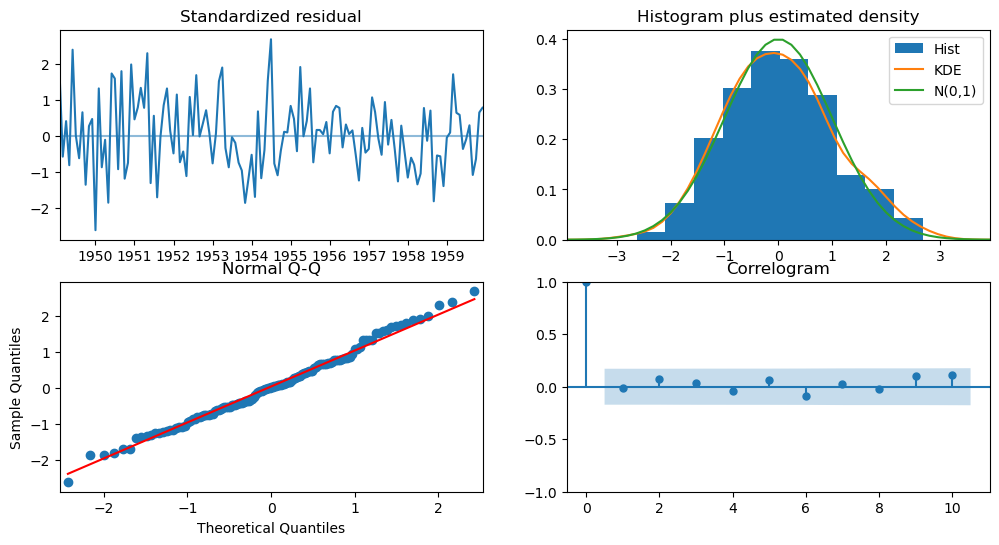

In [71]:
model_auto_ARIMA.plot_diagnostics(figsize=(12,6))
plt.show()

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


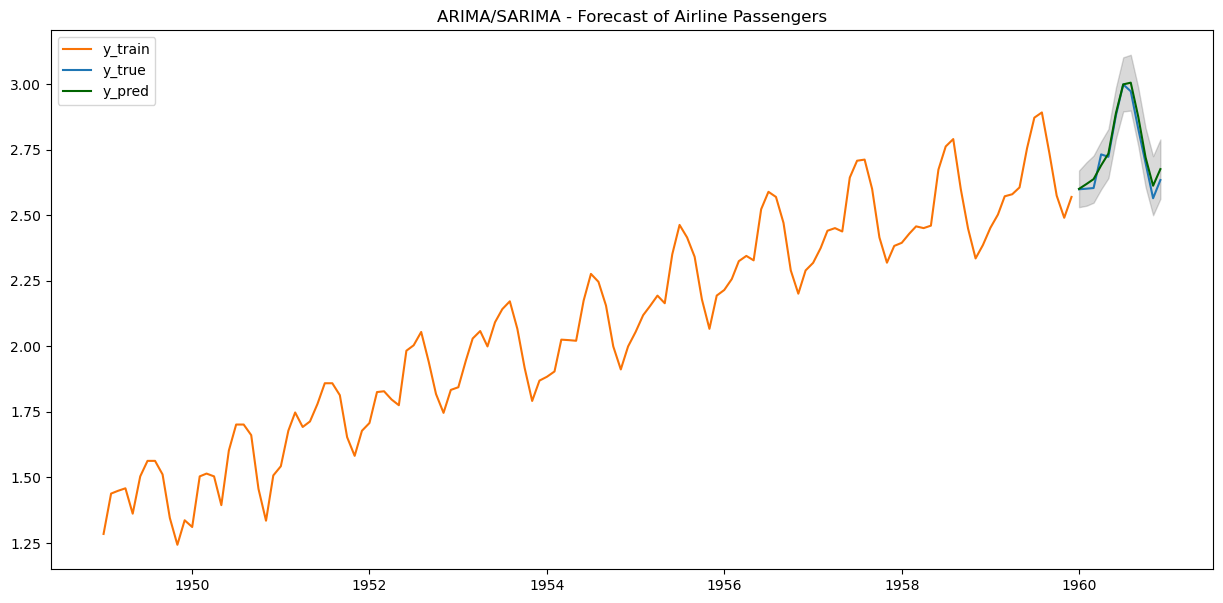

In [76]:
# Your code showing train, test, predictions and confidence interval
predictions_log = forecast(model_auto_ARIMA,test.index,y_true=test_log,y_train=train_log)

In [73]:
# Make predictions and transform back
predictions = np.exp(predictions_log)
from sklearn.metrics import mean_squared_error
# Your code calculating the RMSE and MAPE
df_result = pd.DataFrame(columns=['MAPE','MSE'], index = ['log_test','test'])
df_result.loc['log_test','MAPE'] = mean_absolute_percentage_error(test_log, predictions_log)
df_result.loc['log_test','MSE'] = mean_squared_error(test_log, predictions_log)
df_result.loc['test','MAPE'] = mean_absolute_percentage_error(test, predictions)
df_result.loc['test','MSE'] = mean_squared_error(test, predictions)
df_result

,MAPE,MSE
log_test,0.942091,0.000926
test,2.581944,0.22101


**Conclusions**
- How does `auto_arima` perform with respect to your previous models ? Can you explain why ?
 Better (test MAPE	2.581944	test MSE 0.22101) the auto ARIMA (11,1,7) overfit less on train than ARIMA (12,1,12) thanks to the AIC metrics


In [63]:
assert False # something in the following cells breaks the code in the previous cells, do not run them

AssertionError: 

# 4. Cross-Validation

**TODO**
- Perform a cross-validation with your best ARIMA model. 
- Try different step values in the RollingForecastCV. What's the difference ?
- In each case, what's the size of the the data the model is trained on ?
- How many splits did we get ?

In [96]:
import numpy as np
from sktime.forecasting.base import ForecastingHorizon



def time_series_cv(model, error_func, train, val, horizons, step=1):

    '''

    Time series cross validation across multiple horizons for a single model.



    Incrementally adds additional training data to the model and tests

    across a provided list of forecast horizons. Note that function tests a

    model only against complete validation sets.  E.g. if horizon = 15 and 

    len(val) = 12 then no testing is done.  In the case of multiple horizons

    e.g. [7, 14, 28] then the function will use the maximum forecast horizon

    to calculate the number of iterations i.e if len(val) = 365 and step = 1

    then no. iterations = len(val) - max(horizon) = 365 - 28 = 337.

    

    Parameters:

    --------

    model - forecasting model



    error_func - function to measure forecast error



    train - np.array - vector of training data



    val - np.array - vector of validation data



    horizon - list of ints, forecast horizon e.g. [7, 14, 28] days



    step -- step taken in cross validation 

            e.g. 1 in next cross validation training data includes next point 

            from the validation set.

            e.g. 7 in the next cross validation training data includes next 7 points

            (default=1)

            

    Returns:

    -------

    np.array - vector of forecast errors from the CVs.

    '''

    cvs = []



    #change here: max(horizons) + 1

    for i in range(0, len(val) - max(horizons) + 1, step):

        

        train_cv = np.concatenate([train, val[:i]], axis=0)

        model.fit(train_cv)

        

        #predict the maximum horizon

        try:

            preds = model.predict(n_periods=max(horizons))

        # hack to work with sktime Naive Forecasters

        except:

            fh = ForecastingHorizon(list(range(1, max(horizons)+1)), is_relative=True)

            preds = model.predict(fh=fh)

            preds = preds.flatten()

            #preds = model.predict(fh=len(val[i:i+max(horizons)]))

            

        horizon_errors = []

        for h in horizons:

            #would be useful to return multiple prediction errors in one go.

            pred_error = error_func(preds[:h], val[i:i+h])

            horizon_errors.append(pred_error)

        

        cvs.append(horizon_errors)

    

    return np.array(cvs)

# cvs = time_series_cv(model, error_func, train, val, horizons, step=1)


In [109]:
train_log

1949-01-01    1.284512
1949-02-01    1.438480
1949-03-01    1.448815
1949-04-01    1.458615
1949-05-01    1.361803
                ...   
1958-08-01    2.790571
1958-09-01    2.600217
1958-10-01    2.449335
1958-11-01    2.335375
1958-12-01    2.386096
Freq: MS, Length: 120, dtype: float64

In [103]:
train,valid = ts_train_test_split(airline_adj,'1959-01-01')
train_log,valid_log = np.log(train),np.log(valid)
valid_log

1959-01-01    2.452117
1959-02-01    2.502606
1959-03-01    2.572366
1959-04-01    2.580217
1959-05-01    2.606268
1959-06-01    2.755782
1959-07-01    2.872288
1959-08-01    2.892162
1959-09-01    2.736530
1959-10-01    2.574826
1959-11-01    2.490447
1959-12-01    2.569900
1960-01-01    2.599099
1960-02-01    2.601412
1960-03-01    2.603884
1960-04-01    2.732201
1960-05-01    2.722992
1960-06-01    2.881069
1960-07-01    2.998953
1960-08-01    2.972893
1960-09-01    2.829284
1960-10-01    2.699411
1960-11-01    2.564949
1960-12-01    2.634438
Freq: MS, dtype: float64

In [113]:
model_ARIMA.fit(train_log)

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

,order,"(12, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [115]:
# from pmdarima.arima import ARIMA
# mean_absolute_percentage_error
from pmdarima.model_selection import RollingForecastCV, cross_val_score

# Manually create the arima model #Best model:  ARIMA(11,1,7)(0,0,0)[1] intercept

model_best_ARIMA = ARIMA(order=(11,1,7))
# Create a RollingForecastCV instance
# cv = RollingForecastCV(h=12,step=1)
# Call cross_val_score
# cross_val_score(model_best_ARIMA,y=train_log,cv=cv)


cvs = time_series_cv(model=model_best_ARIMA, error_func=mean_absolute_percentage_error, train = train_log, val=valid_log, horizons=[12], step=1)


/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

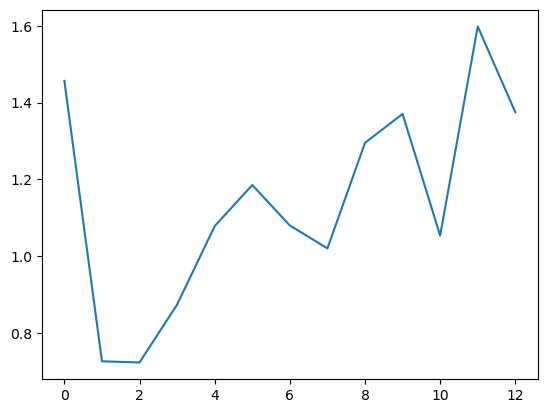

In [119]:
plt.plot(cvs)

# 5. The Final Forecast

**TODO**
- Following the same methodology as above, produce your final forecast with your best model!
- Plot the predictions of the **Naive**, **Seasonal Naive**, and your best **SARIMA** model along with the test data, and compare they performances!

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml6/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


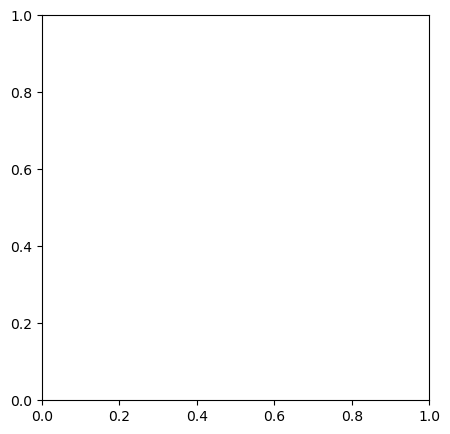

In [ ]:
# Your code here
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

# from pmdarima.utils import acf, pacf
# from pmdarima import ARIMA

airline = load_airline().dropna()
airline = airline / airline.index.days_in_month
train, test = ts_train_test_split(airline, '1960-01-01')
train_log = np.log(train).dropna()

HORIZON = 12  # We plan to make forecasts for the following 12 months
PERIOD = 12  # Expected period of seasonality
# Define the length of time into the future for which forecasts are to be prepared
fh = ForecastingHorizon(test.index, is_relative=False)

# Define models


# Fit models
model_naive.fit(y= train_log,fh=fh)
model_naive_seasonal.fit(y= train_log,fh=fh)
model_best_ARIMA.fit(train_log)

# Create predictions
pred_naive = np.exp(model_naive.predict(fh))
pred_naive_seasonal = np.exp(model_naive_seasonal.predict(fh))
pred_ARIMA = np.exp(model_best_ARIMA.predict(len(test.index)))


<Axes: xlabel='Period'>

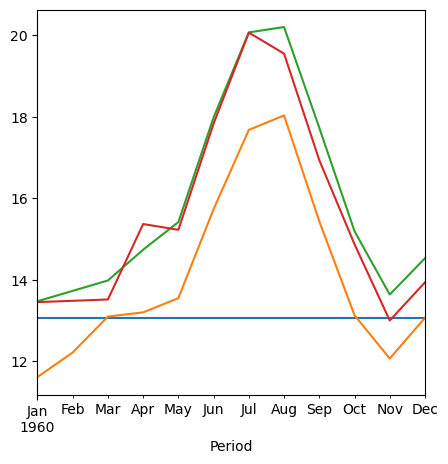

In [ ]:
# Plot predictions
fig,ax = plt.subplots(1,1,figsize=(5,5))
pred_naive.plot(ax=ax)
pred_naive_seasonal.plot(ax=ax,label='naive seasonal')
pred_ARIMA.plot(ax=ax,label='ARIMA')
test.plot(ax=ax,label='test')
ax.legend()



# Bonus

### B1. Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Have some time left ?** 
* Add a method `get_cv` Which performs cross validation
* To further automatize the process, add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit such as a log transformation.

In [ ]:
# Write your class here




### B2. Test this method on all the other [11 datasets] of pmdarima

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']

def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pm.datasets, 'load_'+ds_name)(as_series=True).dropna()
    
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    
    return ds.dropna()

### B3. Want some more ?

Choose your poison: https://data.world/datasets/time-series